In [164]:
import sys

sys.path.append("..")

In [165]:
import ast
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

tqdm.pandas()

In [166]:
df = pd.read_csv("../out/rec6.csv")
df = df.set_index("user_id", drop=True)
list_cols = [
    "target_items",
    "before_rerank_rec",
    "before_rerank_rec_value",
    "after_rerank_rec",
    "after_rerank_rec_value",
]

for col in list_cols:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x))

In [167]:
movie_df = pd.read_csv("../data/ml-25m/movies.csv")
movie_df = movie_df.set_index("movieId")
movie_df.genres = movie_df.genres.progress_apply(lambda s: s.split("|"))
movie_df = pd.concat([movie_df, pd.get_dummies(movie_df.genres.explode()).groupby(level=0).sum()], axis=1)

all_genres = movie_df.genres.explode().unique().tolist()
row_sum = movie_df[all_genres].sum(axis=1)
for genre in all_genres:
    movie_df[genre] /= row_sum

genre_vec = {movie_id: vec for movie_id, vec in zip(movie_df.index, movie_df[all_genres].values)}

100%|██████████| 62423/62423 [00:00<00:00, 1468363.95it/s]


In [168]:
def calc_hit_ratio(target_items: list[int], recommendation: list[int], k: int) -> float:
    if len(set(target_items) & set(recommendation[:k])) > 0:
        return 1
    return 0


def calc_precision(target_items: list[int], recommendation: list[int], k: int) -> float:
    return len(set(target_items) & set(recommendation[:k])) / k


def calc_recall(target_items: list[int], recommendation: list[int], k: int) -> float:
    return len(set(target_items) & set(recommendation[:k])) / len(target_items)


def calc_mrr(target_items: list[int], recommendation: list[int], k: int) -> float:
    s = set(target_items)
    for i, item in enumerate(recommendation[:k]):
        if item in s:
            return 1 / (i + 1)
    return 0


def calc_map(target_items: list[int], recommendation: list[int], k: int) -> float:
    s = set(target_items)
    precision_sum = 0
    for i, item in enumerate(recommendation[:k]):
        if item in s:
            precision_sum += calc_precision(target_items, recommendation, i + 1)
    return precision_sum / len(target_items)


def calc_genre_diversity(
    target_items: list[int], recommendation: list[int], k: int
) -> float:
    return np.mean([genre_vec[item] for item in recommendation[:k]], axis=0).var()


def calc_genre_diversity2(
    target_items: list[int], recommendation: list[int], k: int
) -> float:
    div_sum = 0
    for i, item_i in enumerate(recommendation[:k]):
        for j, item_j in enumerate(recommendation[:k]):
            if i == j:
                continue
            div_sum += ((genre_vec[item_i] - genre_vec[item_j]) ** 2).sum()
    div_sum /= k * (k - 1)
    return math.sqrt(div_sum)


metrics = [
    ("HR", calc_hit_ratio),
    ("Precision", calc_precision),
    ("Recall", calc_recall),
    ("MRR", calc_mrr),
    ("MAP", calc_map),
    ("GenreDiversity", calc_genre_diversity),
]

ks = list(range(5, 31))
recs = ["before_rerank_rec", "after_rerank_rec"]


df = pd.concat(
    [
        df,
        pd.concat(
            [
                df.apply(
                    lambda row: metric_fn(row["target_items"], row[rec], k),
                    axis=1,
                ).rename(f"{rec}_{metric_name}@{k}")
                for metric_name, metric_fn in metrics
                for k in tqdm(ks)
                for rec in recs
            ],
            axis=1,
        ),
    ],
    axis=1,
)

  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


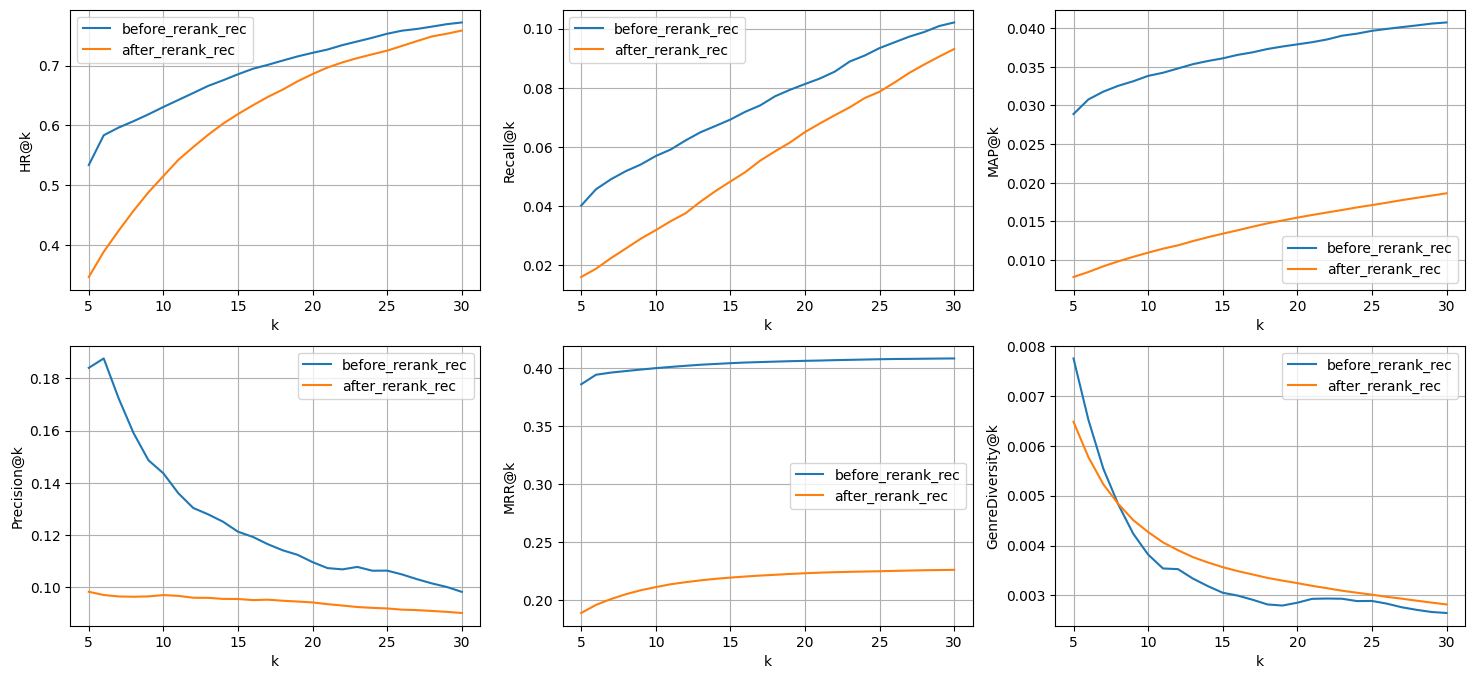

In [169]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

for i, (metric_name, _) in enumerate(metrics):
    for rec in recs:
        metric_values = [df[f"{rec}_{metric_name}@{k}"].mean() for k in ks]
        axes[i % 2, i // 2].plot(ks, metric_values, label=rec)
    axes[i % 2, i // 2].set_xlabel("k")
    axes[i % 2, i // 2].set_ylabel(f"{metric_name}@k")
    axes[i % 2, i // 2].grid()
    axes[i % 2, i // 2].legend()

plt.show()